In [1]:
import numpy as np 

In [2]:
# M = Manifold("m003(-3, 1)") 
# G = M.fundamental_group()
# print(G)
# a = G.O31('a')
# b = G.O31('b')
# reps = {'a': a, 'b': b}

# import json

# a = G.O31('a')
# b = G.O31('b')

# # Convert numpy arrays to lists for JSON serialization
# a_list = a.tolist()
# b_list = b.tolist()

# # Create dictionary with representations
# reps = {
#     'a': a_list,
#     'b': b_list
# }

# # Save to JSON file
# with open('/Users/nicholaslyu/Code/mera/code/o31_reps.json', 'w') as f:
#     json.dump(reps, f)

In [3]:
import numpy as np 

reps = {
    'a': [
        [2.911765004969895, -1.327238097353251, -1.545882238950561, -1.824023733507505],
        [0.214486455935371, -0.957586413882210, 0.355231162804379, 0.053324672531335],
        [2.671911126693084, -1.274270677223860, -1.513151071413262, -2.055654918801949],
        [0.541536642750342, -0.469918576118812, -0.986882238545383, 0.313850146572269]
    ],
    'b': [
        [9.865656965497124, -1.784672569481886, -7.901045818739012, 5.542527054583283],
        [-0.637317855564850, 1.086032896777496, 0.280671152037801, -0.384617083022365],
        [9.338977823686939, -1.692407562856014, -7.735533591802524, 5.051117052951483],
        [-2.951017878719753, 0.375959264527696, 1.873304242327364, -2.461278604225403]
    ]
}
a, b = np.array(reps['a']), np.array(reps['b'])
A, B = np.linalg.inv(a), np.linalg.inv(b)
r1 = a @ a @ b @ b @ a @ a @ B @ a @ B
r2 = a @ a @ b @ b @ A @ b @ A @ b @ b 

In [6]:
from utils import * 

In [15]:
from collections import deque

# Initialize caches using hashable matrix representations
cayley_cache = {
    matrix_to_tuple(a): ['a'], 
    matrix_to_tuple(b): ['b'],
    matrix_to_tuple(A): ['A'],
    matrix_to_tuple(B): ['B']
}
rev_cayley_cache = {v: matrix_to_tuple(k) for k, v in zip([a,b,A,B], ['a','b','A','B'])}

def next_words(word):
    """
    Given a string denoting a word, return words which follow 
    from adding a non-inverse letter. 
    """
    if word[-1] == 'a': 
        return [word + 'a', word + 'b', word + 'B']
    elif word[-1] == 'b': 
        return [word + 'a', word + 'b', word + 'A']
    elif word[-1] == 'A': 
        return [word + 'A', word + 'b', word + 'B']
    elif word[-1] == 'B': 
        return [word + 'a', word + 'A', word + 'B'] 
    raise RuntimeError(f"Invalid word: {word}")

def find_similar_rep(rep, rep_dict, threshold=1e-8):
    """Find if rep is similar to any existing rep in the dictionary"""
    for existing_rep_tuple in rep_dict:
        existing_rep = np.array(existing_rep_tuple)
        if cosine_similarity(rep, existing_rep) > 1 - threshold:
            return existing_rep_tuple
    return None

queue = deque()
edges = list(map(lambda x: ('e', x[0]), cayley_cache.values()))
for word in rev_cayley_cache:
    queue.extend(next_words(word))
radius = 5

while queue:
    word = queue.popleft()
    print(f"Processing {word}")
    if len(word) > radius: 
        continue 

    prefix = word[:-1]
    # Convert tuple back to array for matrix multiplication
    prefix_matrix = np.array(rev_cayley_cache[prefix])
    last_letter_matrix = np.array(rev_cayley_cache[word[-1]])
    rep = prefix_matrix @ last_letter_matrix
    similar_rep = find_similar_rep(rep, cayley_cache)

    if similar_rep is not None: 
        print(f"Found dup for {word}: {cayley_cache[similar_rep]}")
        cayley_cache[similar_rep].append(word)
        rev_cayley_cache[word] = similar_rep
        edges.append((prefix, cayley_cache[similar_rep][0]))
        continue 
    rep_tuple = matrix_to_tuple(rep)
    cayley_cache[rep_tuple] = [word]
    rev_cayley_cache[word] = rep_tuple
    edges.append((prefix, word))
    queue.extend(next_words(word))


Processing aa
Processing ab
Processing aB
Processing ba
Processing bb
Processing bA
Processing AA
Processing Ab
Processing AB
Processing Ba
Processing BA
Processing BB
Processing aaa
Processing aab
Processing aaB
Processing aba
Processing abb
Processing abA
Processing aBa
Processing aBA
Processing aBB
Processing baa
Processing bab
Processing baB
Processing bba
Processing bbb
Processing bbA
Processing bAA
Processing bAb
Processing bAB
Processing AAA
Processing AAb
Processing AAB
Processing Aba
Processing Abb
Processing AbA
Processing ABa
Processing ABA
Processing ABB
Processing Baa
Processing Bab
Processing BaB
Processing BAA
Processing BAb
Processing BAB
Processing BBa
Processing BBA
Processing BBB
Processing aaaa
Processing aaab
Processing aaaB
Processing aaba
Processing aabb
Processing aabA
Processing aaBa
Processing aaBA
Processing aaBB
Processing abaa
Processing abab
Processing abaB
Processing abba
Processing abbb
Processing abbA
Processing abAA
Processing abAb
Processing abAB
Proc

In [30]:
import math 

# Extract the canonical words 
canonical_words = list(map(lambda x: x[0], cayley_cache.values()))
canonical_words_by_length = {l: 
        list(filter(lambda x: len(x) == l, canonical_words))
        for l in range(1, radius + 1)}
num_canonical_words_by_length = {l: len(words) for l, words in canonical_words_by_length.items()}

def word_coords(word):
    if word == 'e': 
        return 0, 0
    word_len = len(word)
    word_idx = canonical_words_by_length[word_len].index(word)
    word_degree = num_canonical_words_by_length[word_len]
    return word_len * math.sin(word_idx / word_degree * 2 * math.pi), word_len * math.cos(word_idx / word_degree * 2 * math.pi)

len(canonical_words)

436

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

def visualize_matrix(mat):
    """
    Visualizes a numpy matrix using matplotlib with a color scheme:
    - White (0) as the center
    - Red for positive values
    - Blue for negative values
    """
    # Ensure mat is a numpy array
    mat = np.array(mat)

    # Create the colormap centered at 0
    cmap = plt.cm.bwr  # Blue-White-Red colormap
    S = max(-np.min(mat), np.max(mat))
    norm = TwoSlopeNorm(vmin=-S, vcenter=0, vmax=S)

    # Plot the matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(mat, cmap=cmap, norm=norm)
    plt.colorbar(label='Value')  # Add a color bar
    plt.title("Matrix Visualization")
    plt.gca().xaxis.set_visible(False)  # Turn off x-axis labels
    plt.gca().yaxis.set_visible(False)  # Turn off y-axis labels
    plt.show()


In [42]:
import networkx as nx
import plotly.graph_objects as go

# Step 1: Create a graph object
G = nx.Graph()

# Step 2: Add nodes with labels (attributes)
nodes_with_labels = {
    0: "Node A",
    1: "Node B",
    2: "Node C",
    3: "Node D"
}
for node in canonical_words:
    G.add_node(node, label=node)

initial_pos = {node: tuple(list(word_coords(node)) + [np.random.rand() * 1e-2]) for node in canonical_words + ['e']}
G.add_edges_from(edges)

In [ ]:
import networkx as nx
import plotly.graph_objects as go

# Step 1: Create a graph object
G = nx.Graph()

# Step 2: Add nodes with labels (attributes)
nodes_with_labels = {
    0: "Node A",
    1: "Node B",
    2: "Node C",
    3: "Node D"
}
for node, label in nodes_with_labels.items():
    G.add_node(node, label=label)

# Step 3: Add edges
edges = [
    (0, 1),  # Edge between Node A and Node B
    (1, 2),  # Edge between Node B and Node C
    (2, 3),  # Edge between Node C and Node D
    (0, 3),  # Edge between Node A and Node D
    (1, 3)   # Edge between Node B and Node D
]
G.add_edges_from(edges)

# Step 4: Define custom initial positions for nodes
initial_pos = {
    0: (0, 0, 0),  # Node A
    1: (1, 0, 0),  # Node B
    2: (1, 1, 0),  # Node C
    3: (0, 1, 0)   # Node D
}

In [81]:
final_pos = initial_pos.copy()

def hyperboloid_to_disk(vec):
    x = np.array(vec[1:]) / (1 + vec[0])
    return x # np.log((1 + x) / (1 - x))

In [82]:
poincare_pos = {
    k: np.array([0, 0, 0]) if k == 'e' else hyperboloid_to_disk(
        (np.array(rev_cayley_cache[k]) @ np.array([1, 0, 0, 0]).reshape(-1, 1)).reshape(-1)
    ) for k in initial_pos.keys()
}
poincare_pos

{'a': array([0.05483112, 0.6830449 , 0.13843793]),
 'b': array([-0.05865433,  0.859495  , -0.2715913 ]),
 'A': array([0.33929392, 0.39518791, 0.46629175]),
 'B': array([ 0.16424893,  0.72715767, -0.5100959 ]),
 'aa': array([ 0.34282423,  0.57673069, -0.24312905]),
 'ab': array([ 0.27355885,  0.88796185, -0.20915153]),
 'aB': array([ 0.11555733,  0.93151996, -0.19929831]),
 'ba': array([-0.09623552,  0.79191726, -0.430789  ]),
 'bb': array([-0.34569245,  0.65050595, -0.49280523]),
 'bA': array([-0.02700475,  0.87916127, -0.38360001]),
 'AA': array([-0.05725844,  0.2045097 ,  0.68128976]),
 'Ab': array([ 0.49025051,  0.58475336, -0.33229466]),
 'AB': array([0.34907127, 0.83667705, 0.0097036 ]),
 'Ba': array([ 0.17072252,  0.52424972, -0.62347242]),
 'BA': array([ 0.21876765,  0.68952296, -0.6194787 ]),
 'BB': array([ 0.4385751 ,  0.74513843, -0.19477899]),
 'aaa': array([ 0.01655118,  0.78369445, -0.25845458]),
 'aab': array([ 0.16807294,  0.8752737 , -0.37730851]),
 'aaB': array([ 0.258

In [85]:
# Step 3: Apply the spring layout for adjustments based on the random placement
# Spring layout in 3D with initial positions provided
# final_pos = nx.spring_layout(G, dim=3, pos=initial_pos, iterations=100)
final_pos = poincare_pos
# Step 4: Extract node and edge positions
# Nodes
x_nodes = [final_pos[node][0] for node in G.nodes()]
y_nodes = [final_pos[node][1] for node in G.nodes()]
z_nodes = [final_pos[node][2] for node in G.nodes()]

# Edges
x_edges = []
y_edges = []
z_edges = []
for edge in G.edges():
    x_edges += [final_pos[edge[0]][0], final_pos[edge[1]][0], None]
    y_edges += [final_pos[edge[0]][1], final_pos[edge[1]][1], None]
    z_edges += [final_pos[edge[0]][2], final_pos[edge[1]][2], None]

# Step 5: Visualize using Plotly
fig = go.Figure()

# Add edges
fig.add_trace(go.Scatter3d(
    x=x_edges,
    y=y_edges,
    z=z_edges,
    mode='lines',
    line=dict(color='gray', width=0.5),
    hoverinfo='none'
))

# Add nodes
fig.add_trace(go.Scatter3d(
    x=x_nodes,
    y=y_nodes,
    z=z_nodes,
    mode='markers',
    marker=dict(size=3, color='blue', opacity=0.8),
    text=list(G.nodes),
    hoverinfo='text'
))

# Update layout for better visuals
fig.update_layout(
    showlegend=False,
    scene=dict(
        xaxis=dict(showbackground=False),
        yaxis=dict(showbackground=False),
        zaxis=dict(showbackground=False)
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

# Show the plot
fig.show()


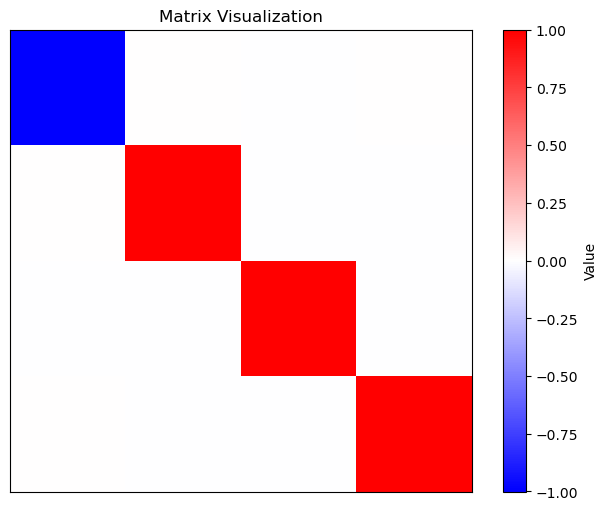

In [80]:
gamma = np.diag([-1, 1, 1, 1])
visualize_matrix(np.transpose(a) @ gamma @ a)

In [65]:
b

array([[ 9.86565697, -1.78467257, -7.90104582,  5.54252705],
       [-0.63731786,  1.0860329 ,  0.28067115, -0.38461708],
       [ 9.33897782, -1.69240756, -7.73553359,  5.05111705],
       [-2.95101788,  0.37595926,  1.87330424, -2.4612786 ]])

In [66]:
A

array([[ 2.911765  , -0.21448646, -2.67191113, -0.54153664],
       [ 1.3272381 , -0.95758641, -1.27427068, -0.46991858],
       [ 1.54588224,  0.35523116, -1.51315107, -0.98688224],
       [ 1.82402373,  0.05332467, -2.05565492,  0.31385015]])

In [67]:
B

array([[ 9.86565697,  0.63731786, -9.33897782,  2.95101788],
       [ 1.78467257,  1.0860329 , -1.69240756,  0.37595926],
       [ 7.90104582,  0.28067115, -7.73553359,  1.87330424],
       [-5.54252705, -0.38461708,  5.05111705, -2.4612786 ]])